We first import necessary packages and load MNIST data

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle
import numpy as np
import dynet as dy
import random

mnist = fetch_mldata('MNIST original')
X = mnist.data.astype('float64')
X /= 255.
noise_ratio = 0.6 # add 50% noise
noise = np.random.normal(scale = noise_ratio, size = X.shape)
X += noise
y = mnist.target
print(X.shape)
X_train, y_train = X[:50000], y[:50000]
X_dev, y_dev = X[50000:60000], y[50000:60000]
X_test, y_test = X[60000:70000], y[60000:70000]

#X_train, y_train = shuffle(X_train, y_train, noise)
#X_test, y_test = shuffle(X_test, y_test, noise)
X_test_original = X_test - noise[60000:70000]

/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


(70000, 784)


next, we define simple autoencoder class. We use Dynet for automatic differentiation

In [2]:
class Autoencoder(object):
    
    def __init__(self, in_size = 784, hid_size = 256, out_size = 784):
        
        self.model = dy.Model()
        self.W1 = self.model.add_parameters((hid_size, in_size))
        self.b1 = self.model.add_parameters((hid_size, 1))
        
        self.W2 = self.model.add_parameters((out_size, hid_size))
        self.b2 = self.model.add_parameters((out_size, 1))
        
        self.trainer = dy.AdamTrainer(self.model)
        
    def forward(self, x):
        
        W1, b1, W2, b2 = dy.parameter(self.W1), dy.parameter(self.b1), dy.parameter(self.W2), dy.parameter(self.b2)
        
        z = W1 * x + b1 # hidden encoding of the input
        x_hat = dy.logistic(W2 * z + b2) # reconstruction of the input
        
        return x_hat

    def get_encoding_as_np_array(self, x):
        
        dy.renew_cg()

        W1, b1, W2, b2 = dy.parameter(self.W1), dy.parameter(self.b1), dy.parameter(self.W2), dy.parameter(self.b2)

        x_expr = dy.vecInput(len(x))
        x_expr.set(x)
        
        z = W1 * x_expr + b1 # hidden encoding of the input
        
        return z.npvalue()
    
    def get_reconstruction_as_np_array(self, x):
        
        x = self.prepare(x)
        return self.forward(x).npvalue()
    
    def prepare(self, x):
        
        x_expr = dy.vecInput(len(x))
        x_expr.set(x)
        return x_expr

        
    def train(self, train, dev, epochs = 5, batch_size = 32):
        
        
        dy.renew_cg()
        
        for i in range(epochs):
            
            random.shuffle(train)
            loss_values = []
            print("Epoch {}/{}".format(i, epochs))
            dev_error = self.test(dev)
            print("dev set average error: {}".format(dev_error))
            
            for j, x in enumerate(train):
                
                x = self.prepare(x)
                
                if j % 5000 == 0:
                    print("{}/{}".format(j, len(train)))
                    
                reconstruction = self.forward(x)
                loss = dy.squared_distance(x, reconstruction)
                loss_values.append(loss)
                
                if j % batch_size == 0:
                    
                    loss_sum = dy.esum(loss_values)
                    loss_sum.backward()
                    self.trainer.update()
                    loss_values = []
                    dy.renew_cg()                    
            
    def test(self, dev):

            total_error = 0.

            for i, x in enumerate(dev):

                dy.renew_cg()
                x = self.prepare(x)
                
                reconstruction = self.forward(x)
                loss = dy.squared_distance(x, reconstruction)
                total_error += loss.npvalue()
            
            return total_error / len(dev)
           

In [3]:
model = Autoencoder()
model.train(X_train, X_dev, epochs = 2)

Epoch 0/4
dev set average error: [477.06398271]
0/50000
5000/50000
10000/50000
15000/50000
20000/50000
25000/50000
30000/50000
35000/50000
40000/50000
45000/50000
Epoch 1/4
dev set average error: [240.29145552]
0/50000
5000/50000
10000/50000
15000/50000
20000/50000
25000/50000
30000/50000
35000/50000
40000/50000
45000/50000
Epoch 2/4
dev set average error: [242.82200678]
0/50000
5000/50000
10000/50000
15000/50000
20000/50000
25000/50000
30000/50000
35000/50000
40000/50000
45000/50000
Epoch 3/4
dev set average error: [248.47444293]
0/50000
5000/50000
10000/50000
15000/50000
20000/50000
25000/50000
30000/50000
35000/50000
40000/50000
45000/50000


Next, we visualize the reconstruction of a few test set examples, and also the hidden activations (encodings) of those examples.

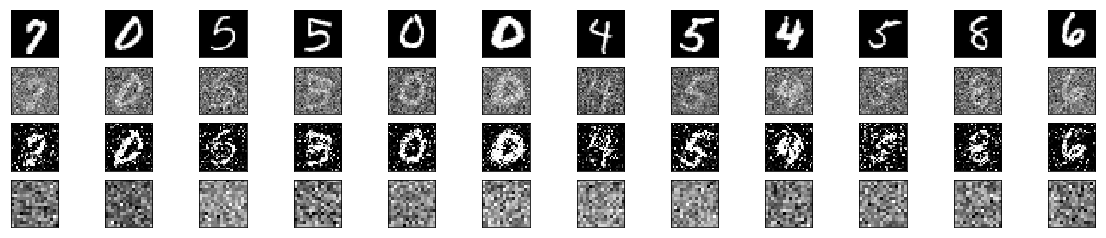

In [4]:
X_test, X_test_original = shuffle(X_test, X_test_original)
reconstructions = [model.get_reconstruction_as_np_array(X_test[i]) for i in range(100)]
hiddens = [model.get_encoding_as_np_array(X_test[i]) for i in range(100)]

# Visualization code from https://github.com/benjaminirving/mlseminars-autoencoders/blob/master/Autoencoders.ipynb

plt.figure(figsize=(20, 4))
n = 12
for i in range(n):

    # display original
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(X_test_original[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noised
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(reconstructions[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encodings
    ax = plt.subplot(4, n, i + 1 + 3*n)
    plt.imshow(hiddens[i].reshape(16, 16))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()